In [211]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# read dataset and split features and label
dataset = pd.read_csv('bc_train.txt',sep='\t', names=[i for i in range(10)])
X= dataset.iloc[:,:-2].values
y= dataset.iloc[:,-1].values

# split train set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


#testset = pd.read_csv('bc_test.txt',sep='\t', names=[i for i in range(10)], encoding='utf-16')
#X_test = testset.iloc[:,:-2].values
#y_test = testset.iloc[:,-1].values
# scaler
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.fit_transform(X_test)

In [222]:
train_test_split?

In [213]:
# Using the SVC from sklearn

# train the classifier
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(X_train, y_train)
classifier.score(X_test,y_test)

0.854

In [215]:
SVC?

Normalized confusion matrix
[[0.85974499 0.14025501]
 [0.66063348 0.33936652]]


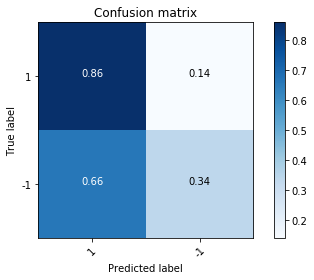

the accuracy rate is 0.7103896103896103


In [158]:
# predict and plot
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
accuracy = (cm[0,0]+cm[1,1])/(sum(cm[0])+sum(cm[1]))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
plot_confusion_matrix(cm,[1,-1],True)
plt.show()
print('the accuracy rate is',accuracy)

In [160]:
class SVM:
    def __init__(self, max_iter=100, kernel='linear'):
        self.max_iter = max_iter
        self._kernel = kernel
    
    def init_args(self, features, labels):
        self.m, self.n = features.shape
        self.X = features
        self.Y = labels
        self.b = 0.0
        
        # 将Ei保存在一个列表里
        self.alpha = np.ones(self.m)
        self.E = [self._E(i) for i in range(self.m)]
        # 松弛变量
        self.C = 1.0
        
    def _KKT(self, i):
        y_g = self._g(i)*self.Y[i]
        if self.alpha[i] == 0:
            return y_g >= 1
        elif 0 < self.alpha[i] < self.C:
            return y_g == 1
        else:
            return y_g <= 1
    
    # g(x)预测值，输入xi（X[i]）
    def _g(self, i):
        r = self.b
        for j in range(self.m):
            r += self.alpha[j]*self.Y[j]*self.kernel(self.X[i], self.X[j])
        return r
    
    # 核函数
    def kernel(self, x1, x2):
        if self._kernel == 'linear':
            return sum([x1[k]*x2[k] for k in range(self.n)])
        elif self._kernel == 'poly':
            return (sum([x1[k]*x2[k] for k in range(self.n)]) + 1)**2
    
        return 0
    
    # E（x）为g(x)对输入x的预测值和y的差
    def _E(self, i):
        return self._g(i) - self.Y[i]
    
    def _init_alpha(self):
        # 外层循环首先遍历所有满足0<a<C的样本点，检验是否满足KKT
        index_list = [i for i in range(self.m) if 0 < self.alpha[i] < self.C]
        # 否则遍历整个训练集
        non_satisfy_list = [i for i in range(self.m) if i not in index_list]
        index_list.extend(non_satisfy_list)
        
        for i in index_list:
            if self._KKT(i):
                continue
            
            E1 = self.E[i]
            # 如果E2是+，选择最小的；如果E2是负的，选择最大的
            if E1 >= 0:
                j = min(range(self.m), key=lambda x: self.E[x])
            else:
                j = max(range(self.m), key=lambda x: self.E[x])
            return i, j
        
    def _compare(self, _alpha, L, H):
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha      
    
    def fit(self, features, labels):
        self.init_args(features, labels)
        
        for t in range(self.max_iter):
            # train
            i1, i2 = self._init_alpha()
            
            # 边界
            if self.Y[i1] == self.Y[i2]:
                L = max(0, self.alpha[i1]+self.alpha[i2]-self.C)
                H = min(self.C, self.alpha[i1]+self.alpha[i2])
            else:
                L = max(0, self.alpha[i2]-self.alpha[i1])
                H = min(self.C, self.C+self.alpha[i2]-self.alpha[i1])
                
            E1 = self.E[i1]
            E2 = self.E[i2]
            # eta=K11+K22-2K12
            eta = self.kernel(self.X[i1], self.X[i1]) + self.kernel(self.X[i2], self.X[i2]) - 2*self.kernel(self.X[i1], self.X[i2])
            if eta <= 0:
                # print('eta <= 0')
                continue
                
            alpha2_new_unc = self.alpha[i2] + self.Y[i2] * (E1 - E2) / eta#此处有修改，根据书上应该是E1 - E2，书上130-131页
            alpha2_new = self._compare(alpha2_new_unc, L, H)
            
            alpha1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (self.alpha[i2] - alpha2_new)
            
            b1_new = -E1 - self.Y[i1] * self.kernel(self.X[i1], self.X[i1]) * (alpha1_new-self.alpha[i1]) - self.Y[i2] * self.kernel(self.X[i2], self.X[i1]) * (alpha2_new-self.alpha[i2])+ self.b 
            b2_new = -E2 - self.Y[i1] * self.kernel(self.X[i1], self.X[i2]) * (alpha1_new-self.alpha[i1]) - self.Y[i2] * self.kernel(self.X[i2], self.X[i2]) * (alpha2_new-self.alpha[i2])+ self.b 
            
            if 0 < alpha1_new < self.C:
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                # 选择中点
                b_new = (b1_new + b2_new) / 2
                
            # 更新参数
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new
            
            self.E[i1] = self._E(i1)
            self.E[i2] = self._E(i2)
        return 'train done!'
            
    def predict(self, data):
        r = self.b
        for i in range(self.m):
            r += self.alpha[i] * self.Y[i] * self.kernel(data, self.X[i])
            
        return 1 if r > 0 else -1
    
    def score(self, X_test, y_test):
        right_count = 0
        for i in range(len(X_test)):
            result = self. (X_test[i])
            if result == y_test[i]:
                right_count += 1
        return right_count / len(X_test)
    
    def _weight(self):
        # linear model
        yx = self.Y.reshape(-1, 1)*self.X
        self.w = np.dot(yx.T, self.alpha)
        return self.w

In [216]:
svm = SVM(max_iter=1000,kernel='poly')
svm.fit(X_train, y_train)

'train done!'

In [217]:
svm.score(X_test,y_test)

0.292

In [192]:
y_pred2=[]
for i in range(len(X_test)):
    y_pred2.append(svm.predict(X_test[i]))

In [193]:
cm = confusion_matrix(y_test,y_pred2)
cm

array([[  0, 354],
       [  0, 146]])

In [169]:
class SVM2():
    def __init__(self,x,y,epochs=200,learning_rate=0.01):
        self.x = np.c_[np.ones((x.shape[0])),x]
        self.y = y
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.w = np.random.uniform(size = np.shape(self.x)[1],)
        
    def get_loss(self,x,y):
        loss = max(0, 1-y*np.dot(x,self.w))
        return loss
    
    def cal_sgd(self, x, y, w):
        if y*np.dot(x,w) < 1:
            w = w - self.learning_rate * (-y * x)
        else:
            w = w
        return w
    
    def train(self):
        for epoch in range(self.epochs):
            randomize = np.arange(len(self.x))
            np.random.shuffle(randomize)
            x = self.x[randomize]
            y = self.y[randomize]
            loss = 0
            for xi,yi in zip(x,y):
                loss += self.get_loss(xi,yi)
                self.w = self.cal_sgd(xi,yi,self.w)
            #print('epoch: {0} loss: {1} w: {2}'.format(epoch, loss, self.w))
        print('training done')
            
    def predict(self,x):
        x_test = np.c_[np.ones((x.shape[0])),x]
        return np.sign(np.dot(x_test,self.w))
    
    def score(self, X_test, y_test):
        right_count = 0
        y_pred = self.predict(X_test)
        for i in range(len(X_test)):
            if y_pred[i] == y_test[i]:
                right_count += 1
        return right_count / len(X_test)

        #    if result == y_test[i]:
        #        right_count += 1
        #return right_count / len(X_test)

In [218]:
svm2 = SVM2(X_train,y_train,epochs=200)

In [219]:
svm2.train()

training done


In [220]:
svm2.score(X_test,y_test)

0.724

In [29]:
aaa=[
    [1,2,3,4],
    [5,6,7,8]
]
bbb=[
    [0,1,2,3],
    [4,5,6,7],
]   
print(np.c_[aaa,bbb])

[[1 2 3 4 0 1 2 3]
 [5 6 7 8 4 5 6 7]]
